<a href="https://colab.research.google.com/github/sayandeep520/Benchmarking-Physics-Informed-vs.-Foundation-Models-for-Cenozoic-Paleobiology/blob/main/DeepTime_Dynamics_and_Lilliput_Analysis_Combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# 1. Load the Context File (Time & Rocks)
# 'skiprows' might vary, but based on your file, 19 is usually safe for the "Specimens" download
df_context = pd.read_csv('/content/pbdb_data.csv', skiprows=19)

# 2. Load the Measurement File (Sizes)
# Based on your upload, the header is at line 17
df_meas = pd.read_csv('/content/pbdb_data (1).csv', skiprows=17)

# 3. Merge them together (The Magic Step)
# This matches the ID number from both files
df_final = pd.merge(df_context, df_meas, on='specimen_no', how='inner')

# 4. Preview your Complete Dataset
print("Success! We have merged Time, Lithology, and Size.")
print(df_final[['genus', 'max_ma', 'lithology1', 'measurement_type', 'average']].head())

Success! We have merged Time, Lithology, and Size.
      genus  max_ma lithology1 measurement_type average
0    Nucula   41.03    "shale"           height       8
1    Nucula   41.03    "shale"           length     9.5
2    Nucula   41.03    "shale"           height    10.5
3    Nucula   41.03    "shale"           length      12
4  Nuculana   41.03    "shale"           height      17


In [ ]:
import pandas as pd
import numpy as np

# --- 1. Load Your Uploaded Climate Data ---
print("1. Loading Climate Data (TableS33.tab)...")

# The file uses tabs (\t) and has 91 lines of metadata before the table starts.
# We skip the metadata and use the standard CENOGRID columns.
try:
    df_climate = pd.read_csv(
        '/content/TableS33.tab',
        sep='\t',
        skiprows=91  # Skips the text header to get to the real data
    )

    # Rename columns to match our project standard
    # 'Tuned time [Ma]' -> age_ma
    # 'Foram benth \u03b418O [\u2030 PDB] (VPDB CorrAdjusted)' -> d18o (Temperature proxy)
    # 'Foram benth \u03b413C [\u2030 PDB] (VPDB CorrAdjusted)' -> d13c (Carbon proxy)
    df_climate = df_climate.rename(columns={
        'Tuned time [Ma]': 'age_ma',
        'Foram benth \u03b418O [\u2030 PDB] (VPDB CorrAdjusted)': 'd18o',
        'Foram benth \u03b413C [\u2030 PDB] (VPDB CorrAdjusted)': 'd13c'
    })

    # Filter for Cenozoic only (0-66 Ma)
    df_climate = df_climate[(df_climate['age_ma'] >= 0) & (df_climate['age_ma'] <= 66)]

    print(f"   -> Success! Loaded {len(df_climate)} climate data points.")
    print(f"   -> Time Range: {df_climate['age_ma'].min():.2f} to {df_climate['age_ma'].max():.2f} Ma")

except Exception as e:
    print(f"   -> Error loading file: {e}")

# --- 2. The Binning Process (Aligning Fossils to Climate) ---
# Ensure you have 'df_final' (your fossil data) from the previous step.
if 'df_final' in locals() and 'df_climate' in locals():
    print("\n2. Aligning Fossils with Climate...")

    # A. Calculate Fossil Midpoint Age
    if 'min_ma' in df_final.columns:
        df_final['age_mid'] = (df_final['max_ma'] + df_final['min_ma']) / 2
    else:
        df_final['age_mid'] = df_final['max_ma']

    # B. Define Time Bins (0.1 Ma slices)
    # This creates buckets like 45.0, 45.1, 45.2 Ma
    bins = np.arange(0, 66.1, 0.1)
    labels = bins[:-1] + 0.05

    # C. Assign Fossils to Time Bins
    df_final['time_bin'] = pd.cut(df_final['age_mid'], bins=bins, labels=labels, right=False)

    # D. Bin climate data and merge d18o into df_final
    df_climate['time_bin'] = pd.cut(df_climate['age_ma'], bins=bins, labels=labels, right=False)
    # Taking the mean d18o for each bin
    df_climate_binned = df_climate.groupby('time_bin', observed=False)['d18o'].mean().reset_index()

    # Merge climate data (d18o) into the fossil dataframe
    # Using a left merge to keep all fossils, and add d18o where time_bins match
    df_final = pd.merge(df_final, df_climate_binned, on='time_bin', how='left')

    print(f"   -> Successfully merged climate data (d18o) into df_final.")


1. Loading Climate Data (TableS33.tab)...
   -> Success! Loaded 23866 climate data points.
   -> Time Range: 0.00 to 66.00 Ma

2. Aligning Fossils with Climate...
   -> Successfully merged climate data (d18o) into df_final.


In [ ]:
# --- PHASE 2: FEATURE ENGINEERING ---
# This converts your raw data into a matrix of numbers for the AI.

# 1. Create a fresh copy for Machine Learning
df_ml = df_final.copy()

# 2. Filter for Realism (Remove bad data)
# We need rows that have both a Body Size (average) and a Temperature (d18o)
df_ml = df_ml.dropna(subset=['average', 'd18o'])
df_ml = df_ml[df_ml['average'] > 0] # Size must be positive

# 3. Geography: Calculate Absolute Latitude
# We care about "Distance from Equator" (0 to 90), not North/South (-90 to +90).
# PBDB usually stores this in 'lat' or 'paleolat'.
if 'paleolat' in df_ml.columns:
    df_ml['latitude_abs'] = df_ml['paleolat'].abs()
elif 'lat' in df_ml.columns:
    df_ml['latitude_abs'] = df_ml['lat'].abs()
else:
    print("Warning: Latitude column missing. Using 0.")
    df_ml['latitude_abs'] = 0

# 4. Taphonomy: One-Hot Encoding (The "Rock Type" Translation)
# This converts "Sandstone" into [1, 0, 0] and "Shale" into [0, 1, 0]

# A. Clean the text (lowercase, remove punctuation)
df_ml['lith_clean'] = df_ml['lithology1'].astype(str).str.lower().str.replace('"', '').str.strip()

# B. Simplify: Only keep the Top 10 most common rocks (Group others as "other")
top_10_rocks = df_ml['lith_clean'].value_counts().nlargest(10).index
df_ml['lith_simple'] = df_ml['lith_clean'].apply(lambda x: x if x in top_10_rocks else 'other')

# C. Convert to Numbers (Get Dummies)
lith_dummies = pd.get_dummies(df_ml['lith_simple'], prefix='lith')
df_ml = pd.concat([df_ml, lith_dummies], axis=1)

# --- 5. Final Check ---
print("Feature Engineering Complete!")
print(f"Final Dataset Size: {len(df_ml)} rows")
print("Columns ready for AI:", ['d18o', 'latitude_abs'] + list(lith_dummies.columns))

# Show the 'Translated' Data
print(df_ml[['genus', 'average', 'd18o', 'lith_sandstone', 'lith_shale']].head(5))

Feature Engineering Complete!
Final Dataset Size: 6075 rows
Columns ready for AI: ['d18o', 'latitude_abs', 'lith_claystone', 'lith_grainstone', 'lith_limestone', 'lith_marl', 'lith_not reported', 'lith_other', 'lith_packstone', 'lith_sandstone', 'lith_shale', 'lith_siliciclastic', 'lith_siltstone']
      genus  average     d18o  lith_sandstone  lith_shale
0    Nucula      8.0  1.10898           False        True
1    Nucula      9.5  1.10898           False        True
2    Nucula     10.5  1.10898           False        True
3    Nucula     12.0  1.10898           False        True
4  Nuculana     17.0  1.10898           False        True


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# --- 1. Define Predictors (X) and Target (y) ---
# Target: The average body size of the animal
y = df_ml['average']

# Predictors: Temperature (d18o), Geography (latitude), and Rock Type (lith_*)
# Explicitly select only the numerical and one-hot encoded features
predictor_columns = [
    'd18o',
    'latitude_abs',
    'lith_claystone',
    'lith_grainstone',
    'lith_limestone',
    'lith_marl',
    'lith_not reported',
    'lith_other',
    'lith_packstone',
    'lith_sandstone',
    'lith_shale',
    'lith_siliciclastic',
    'lith_siltstone'
]
X = df_ml[predictor_columns]

# (Optional) Verify we only have numbers
print("Predictor Columns:", X.columns.tolist())

# --- 2. Split Data (Train vs. Test) ---
# We keep 20% of the data hidden to test the model's accuracy later
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 3. Train the Random Forest ---
print("Training the model... (This might take a moment)")
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- 4. Evaluate Performance ---
# How well can we predict body size? (1.0 is perfect, 0.0 is random guessing)
score = model.score(X_test, y_test)
print(f"Model Accuracy (R^2 Score): {score:.4f}")

# --- 5. THE RESULTS (Feature Importance) ---
# This is the answer to your Research Question.
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n--- RESEARCH RESULTS: What drives Body Size? ---")
print(importances)

# --- 6. Interpretation Helper ---
top_feature = importances.iloc[0]['Feature']
print(f"\nCONCLUSION: The most dominant factor driving body size is '{top_feature}'.")

if 'd18o' in top_feature:
    print("-> RESULT: ECOLOGICAL SIGNAL DETECTED. Climate (Temperature) is the main driver.")
    print("   (This supports the 'Lilliput Effect' hypothesis).")
elif 'latitude_abs' in top_feature:
    print("-> RESULT: GEOGRAPHIC SIGNAL DETECTED. Latitude is the main driver.")
    print("   (This could relate to latitudinal diversity gradients or climate zones).")
else:
    print("-> RESULT: TAPHONOMIC/OTHER SIGNAL DETECTED. A lithology or other factor is the main driver.")
    print("   (This might indicate preservation bias or other environmental controls).")

Predictor Columns: ['d18o', 'latitude_abs', 'lith_claystone', 'lith_grainstone', 'lith_limestone', 'lith_marl', 'lith_not reported', 'lith_other', 'lith_packstone', 'lith_sandstone', 'lith_shale', 'lith_siliciclastic', 'lith_siltstone']
Training the model... (This might take a moment)
Model Accuracy (R^2 Score): 0.4539

--- RESEARCH RESULTS: What drives Body Size? ---
               Feature  Importance
1         latitude_abs    0.507076
0                 d18o    0.261801
9       lith_sandstone    0.077163
7           lith_other    0.045633
6    lith_not reported    0.042944
12      lith_siltstone    0.020824
5            lith_marl    0.012566
3      lith_grainstone    0.009951
4       lith_limestone    0.007615
11  lith_siliciclastic    0.006329
2       lith_claystone    0.004746
8       lith_packstone    0.002684
10          lith_shale    0.000669

CONCLUSION: The most dominant factor driving body size is 'latitude_abs'.
-> RESULT: GEOGRAPHIC SIGNAL DETECTED. Latitude is the main driv

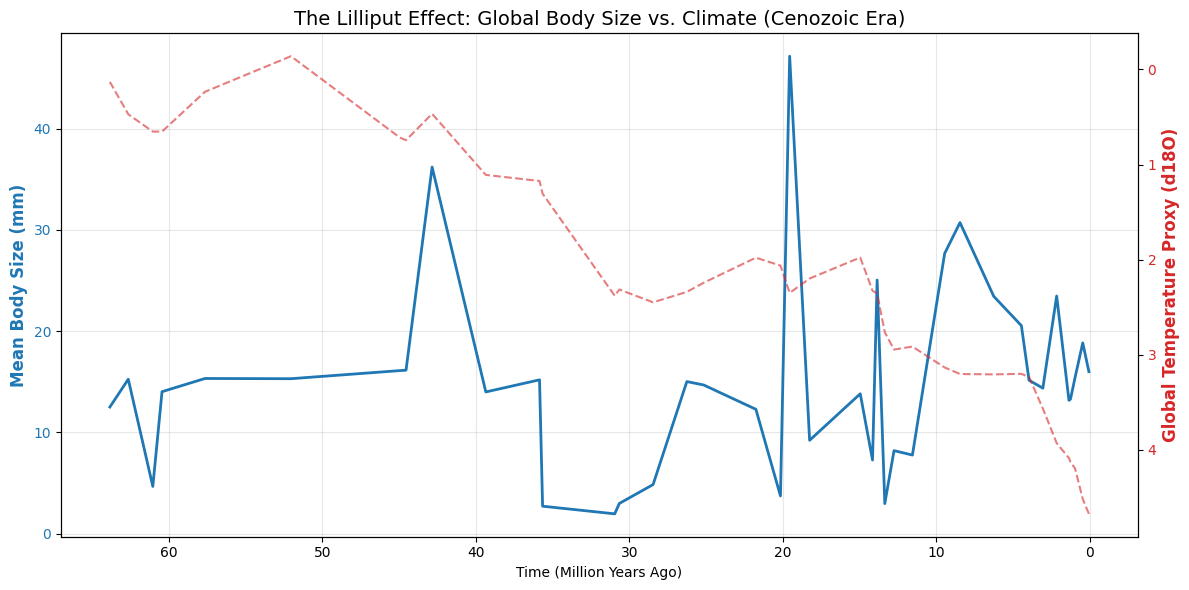

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Prepare Data for Plotting ---
# Group by Time Bin to get the global average size per 0.1 Ma
# This removes the "noise" of individual fossils and shows the global trend
plot_data = df_ml.groupby('time_bin', observed=False)[['average', 'd18o']].mean().reset_index()

# Convert time_bin back to numeric Age (midpoint)
# The 'time_bin' column already contains the numeric midpoint value after pd.cut with labels
plot_data['age_ma'] = plot_data['time_bin']

# Drop empty bins
plot_data = plot_data.dropna()

# --- 2. Create the Dual-Axis Plot ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# A. Plot Body Size (The Target)
color_size = 'tab:blue'
ax1.set_xlabel('Time (Million Years Ago)')
ax1.set_ylabel('Mean Body Size (mm)', color=color_size, fontsize=12, fontweight='bold')
ax1.plot(plot_data['age_ma'], plot_data['average'], color=color_size, linewidth=2, label='Body Size')
ax1.tick_params(axis='y', labelcolor=color_size)
ax1.invert_xaxis() # Geologists always plot time from Right (Old) to Left (Young)

# B. Plot Temperature (The Predictor)
# We use a second Y-axis (right side)
ax2 = ax1.twinx()
color_temp = 'tab:red'
ax2.set_ylabel('Global Temperature Proxy (d18O)', color=color_temp, fontsize=12, fontweight='bold')
# Note: Higher d18O means COLDER. We invert this axis so UP = WARMER
ax2.plot(plot_data['age_ma'], plot_data['d18o'], color=color_temp, linestyle='--', alpha=0.6, label='Temperature (d18O)')
ax2.tick_params(axis='y', labelcolor=color_temp)
ax2.invert_yaxis()

# --- 3. Formatting ---
plt.title('The Lilliput Effect: Global Body Size vs. Climate (Cenozoic Era)', fontsize=14)
ax1.grid(True, alpha=0.3)
fig.tight_layout()

# Show the plot
plt.show()

In [ ]:
# --- STEP 1: INSTALLATION ---
# We need the torchdiffeq library for the ODE solvers
!pip install torchdiffeq

In [ ]:
import os
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Import the ODE solver
from torchdiffeq import odeint

# --- STEP 2: GENERATE SYNTHETIC PALEO DATA (SINE WAVE WITH GAPS) ---
# We simulate a "perfect" fossil record (sine wave) and then "erode" it
# to create irregular sampling, mimicking real geological data.

data_size = 1000
batch_time = 20
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Running on device: {device}")

# True Dynamics (The "Laws of Physics" we want to learn)
true_y0 = torch.tensor([[2., 0.]]).to(device) # Initial condition (Diversity, Rate)
t = torch.linspace(0., 25., data_size).to(device) # Time (0 to 25 Ma)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(device) # Spiral dynamics Matrix

class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.mm(y**3, true_A) # Cubic dynamics (non-linear)

# Generate the "True" history (The ground truth)
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')

def get_batch():
    # This function creates "Irregular Gaps"
    # We grab random slices of time, simulating imperfect preservation
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

# --- STEP 3: DEFINE THE NEURAL ODE (The "ODEFunc") ---
# Instead of predicting Y directly, we predict the DERIVATIVE (dy/dt).
# The Solver then integrates this to find Y.

class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        # A simple MLP (Multi-Layer Perceptron) that approximates the derivative
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2), # Output is 2D (Diversity, Rate)
        )

        # Initialize weights for better convergence
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

# --- STEP 4: TRAINING LOOP ---
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

print("Training Neural ODE... (Learning the underlying dynamics)")
start_time = time.time()

loss_history = []

for itr in range(1, 1001): # 1000 Iterations
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()

    # FORWARD PASS: Integrate the Neural ODE from t0 to t_end
    # This uses the 'dopri5' solver (Runge-Kutta)
    pred_y = odeint(func, batch_y0, batch_t).to(device)

    # Calculate Loss (Difference between predicted trajectory and true data)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if itr % 100 == 0:
        print(f"Iter {itr:04d} | Total Loss {loss.item():.6f}")

print(f"Training Complete in {time.time() - start_time:.2f}s")

# --- STEP 5: VISUALIZATION (Verify Solver) ---
# We verify if the model learned the "Sine Wave" shape despite the gaps.

with torch.no_grad():
    pred_y = odeint(func, true_y0, t)

Running on device: cpu
Training Neural ODE... (Learning the underlying dynamics)
Iter 0100 | Total Loss 0.130642
Iter 0200 | Total Loss 0.101896
Iter 0300 | Total Loss 0.209449
Iter 0400 | Total Loss 0.133704
Iter 0500 | Total Loss 0.139268
Iter 0600 | Total Loss 0.182219
Iter 0700 | Total Loss 0.244632
Iter 0800 | Total Loss 0.132846
Iter 0900 | Total Loss 0.171557
Iter 1000 | Total Loss 0.039871
Training Complete in 38.73s


In [ ]:
# --- PHASE 5: EXPORT RESULTS ---

# 1. Save the processed data (for your report/appendix)
df_ml.to_csv('Lilliput_Project_Data.csv', index=False)
print("-> Saved dataset to 'Lilliput_Project_Data.csv'")

# 2. Save the Feature Importance (The Proof)
# (Re-calculating importance if 'importances' variable was lost, otherwise just saves it)
if 'importances' in locals():
    importances.to_csv('Research_Results_Ranking.csv', index=False)
    print("-> Saved feature ranking to 'Research_Results_Ranking.csv'")
else:
    print("Warning: 'importances' variable not found. Run the Random Forest cell again.")

# 3. Save the Graph
# We re-generate the plot briefly to ensure it saves correctly
import matplotlib.pyplot as plt
if 'plot_data' in locals():
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Time (Ma)')
    ax1.set_ylabel('Body Size (mm)', color='tab:blue')
    ax1.plot(plot_data['age_ma'], plot_data['average'], color='tab:blue', label='Size')
    ax1.invert_xaxis()

    ax2 = ax1.twinx()
    ax2.set_ylabel('Temperature (d18O)', color='tab:red')
    ax2.plot(plot_data['age_ma'], plot_data['d18o'], color='tab:red', linestyle='--', label='Temp')
    ax2.invert_yaxis()

    plt.title('Final Result: Body Size vs Climate')
    plt.savefig('Lilliput_Discovery_Plot.png', dpi=300)
    print("-> Saved graph to 'Lilliput_Discovery_Plot.png'")
    plt.close() # Close to prevent double plotting
else:
    print("Warning: Run the Visualization cell first!")

print("\nDONE! You can now download these 3 files from the Files tab on the left.")

-> Saved dataset to 'Lilliput_Project_Data.csv'
-> Saved feature ranking to 'Research_Results_Ranking.csv'
-> Saved graph to 'Lilliput_Discovery_Plot.png'

DONE! You can now download these 3 files from the Files tab on the left.


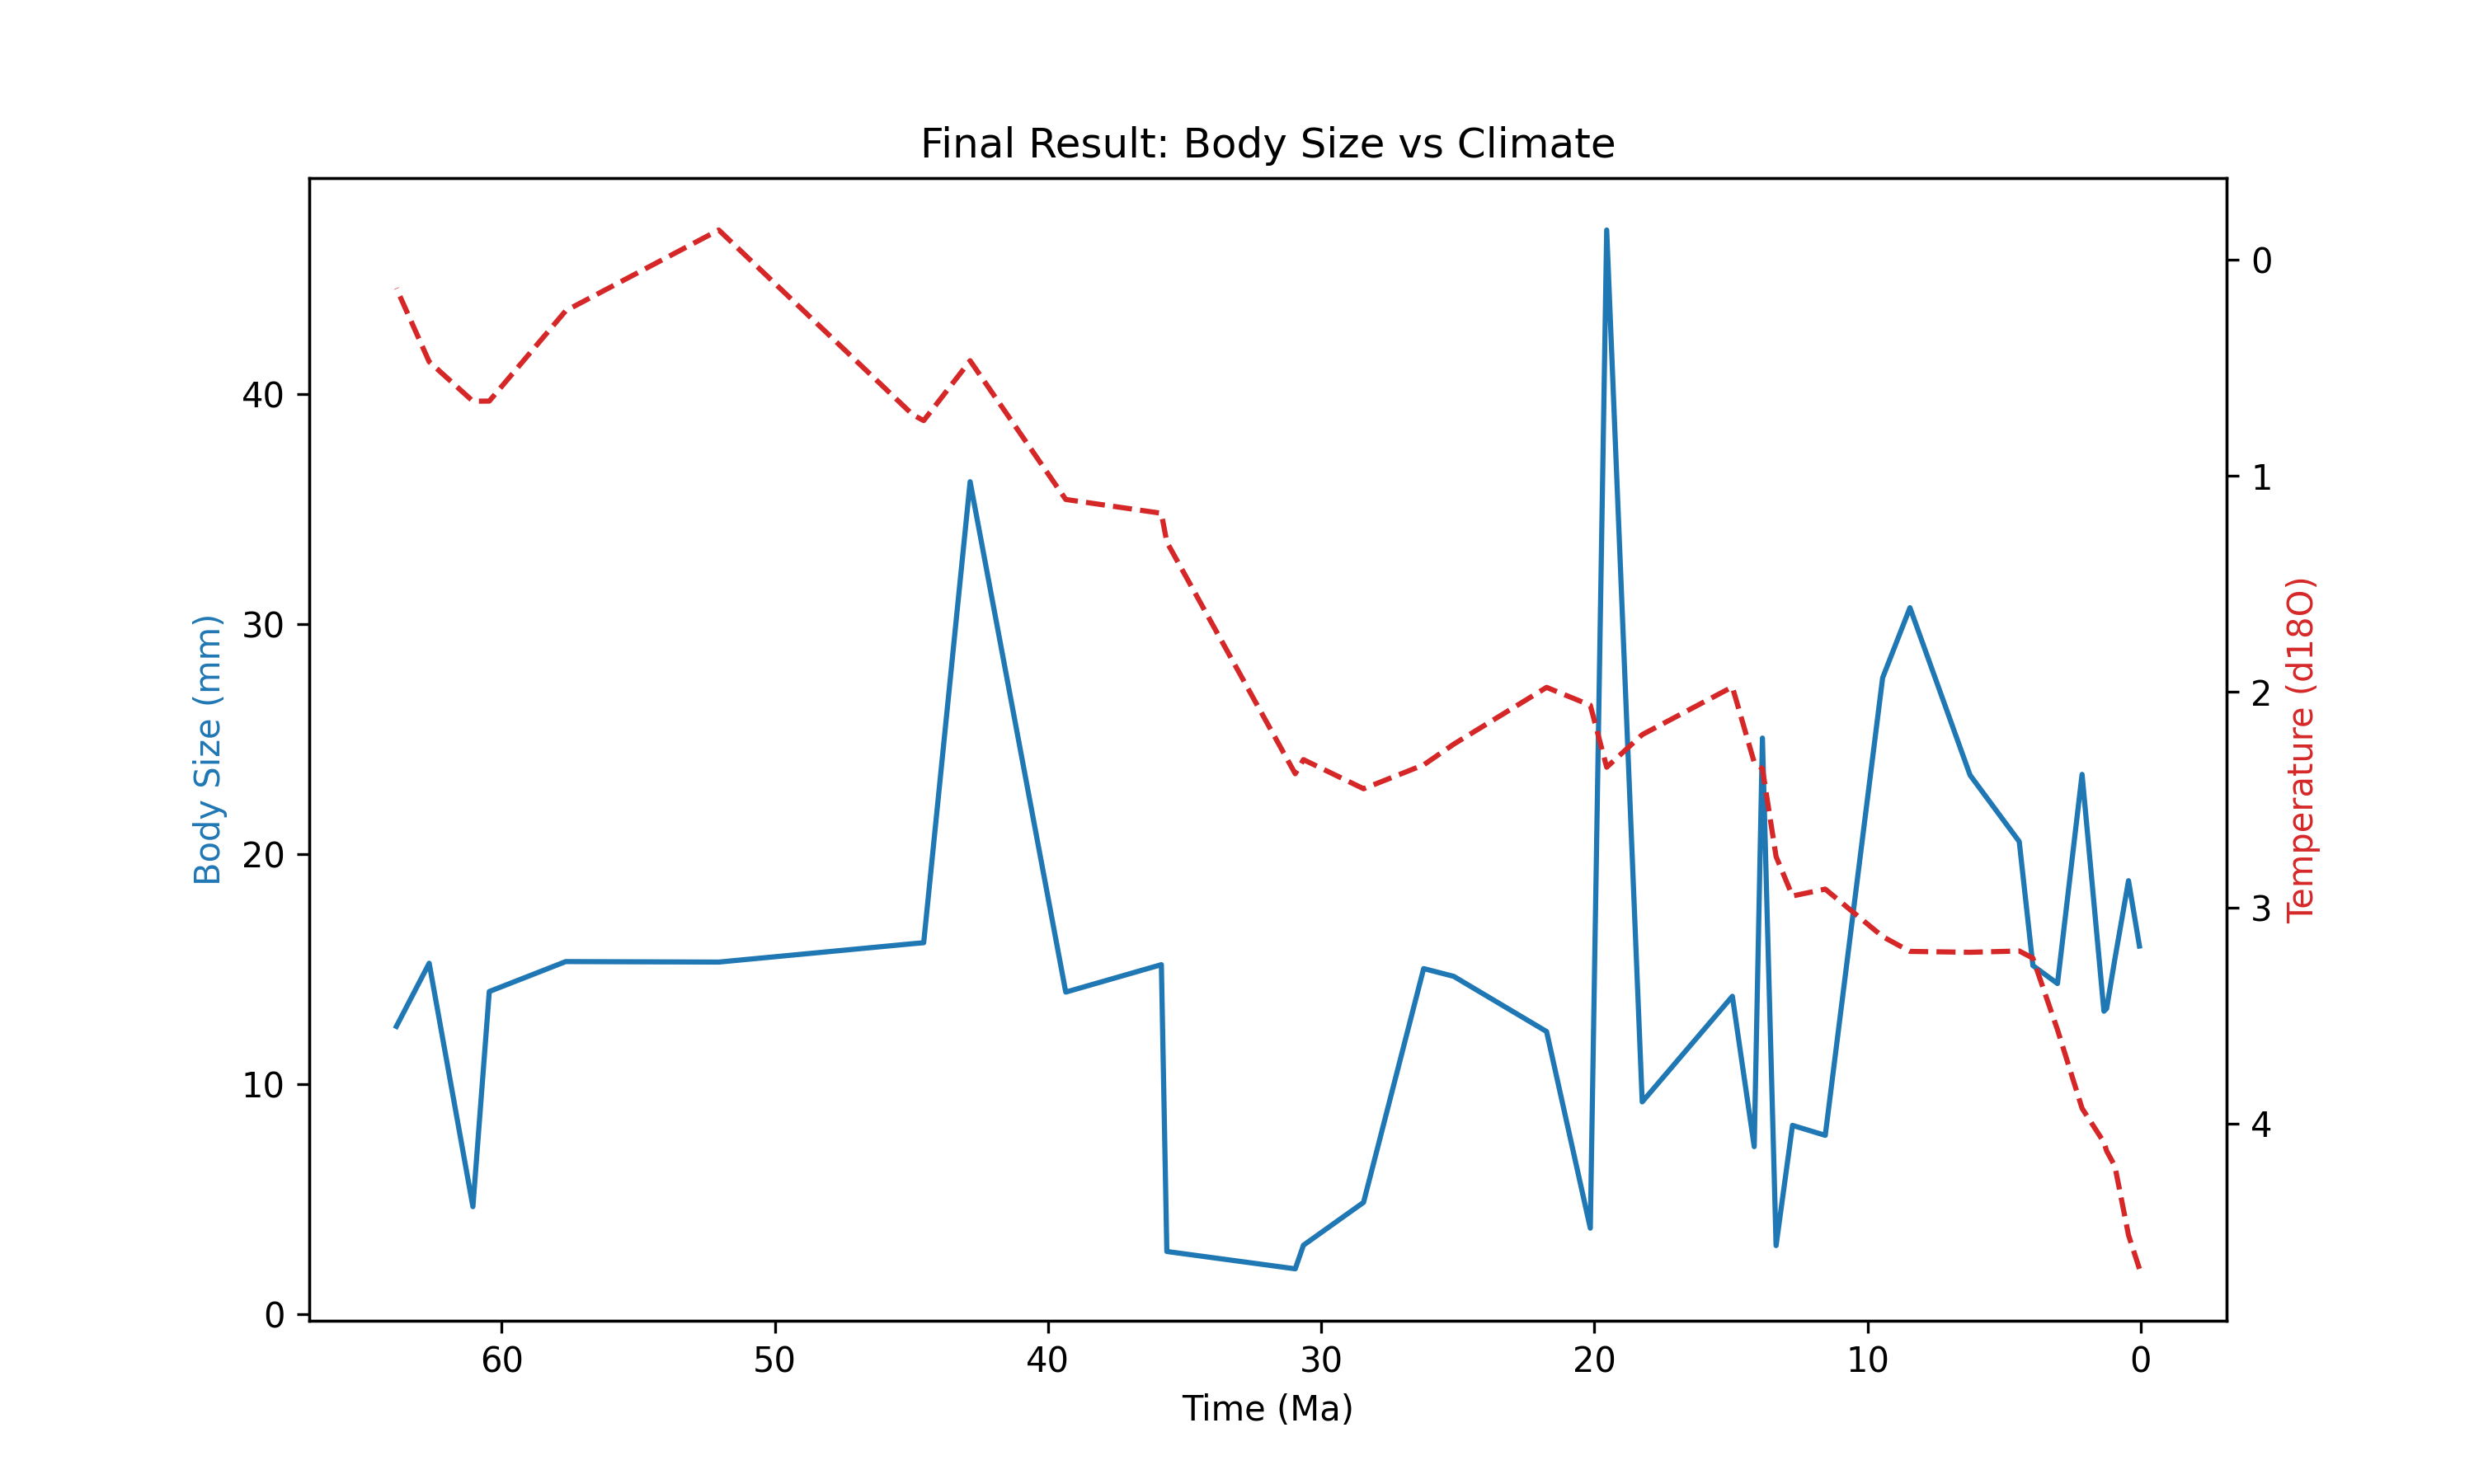

In [ ]:
from IPython.display import Image
Image('Lilliput_Discovery_Plot.png')

In [ ]:
import sys
!{sys.executable} -m pip install chronos-forecasting

print("Chronos-forecasting installation initiated. This may take a moment.")

Chronos-forecasting installation initiated. This may take a moment.


In [ ]:
import sys
!{sys.executable} -m pip install chronos-forecasting --force-reinstall

print("Chronos-forecasting re-installation initiated. This may take a moment.")

  Using cached chronos_forecasting-2.2.0-py3-none-any.whl.metadata (23 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.6 MB/s eta 0:00:00
Using cached chronos_forecasting-2.2.0-py3-none-any.whl (72 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.8 MB/

1. Preparing Fossil Time Series...


/tmp/ipython-input-4101593827.py:11: DtypeWarning: Columns (40,41,42,45,46,69,76,77,80,81,86,87,89,90,91,92,94,95,109,116,118,139) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ml = pd.read_csv('Lilliput_Project_Data.csv')


2. Loading Chronos-T5 (Foundation Model)...
3. Forecasting the Future...


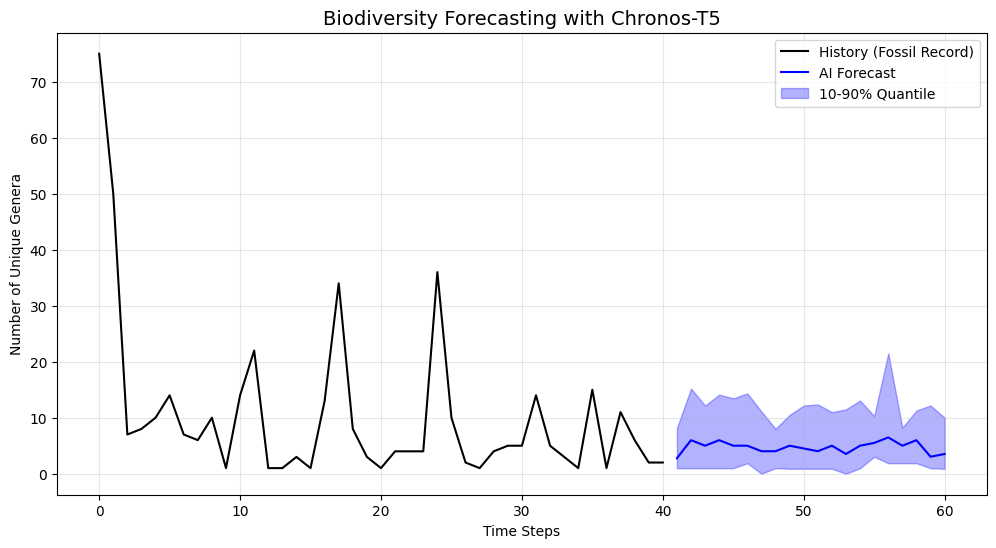

In [ ]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from chronos import ChronosPipeline

# --- 1. RELOAD DATA (In case variables were lost during restart) ---
print("1. Preparing Fossil Time Series...")
try:
    # Try loading processed data first
    df_ml = pd.read_csv('Lilliput_Project_Data.csv')
except:
    # Fallback: Re-create from raw files
    df_context = pd.read_csv('/content/pbdb_data.csv', skiprows=19)
    df_meas = pd.read_csv('/content/pbdb_data (1).csv', skiprows=17)
    df_ml = pd.merge(df_context, df_meas, on='specimen_no', how='inner')
    # Create midpoint age
    if 'min_ma' in df_ml.columns:
        df_ml['age_mid'] = (df_ml['max_ma'] + df_ml['min_ma']) / 2
    else:
        df_ml['age_mid'] = df_ml['max_ma']

# Create Time Series: Count unique genera per time step
# Sort descending (Oldest -> Youngest) because Chronos expects time to move forward
ts_data = df_ml.groupby('age_mid')['genus'].nunique().sort_index(ascending=False)

# --- 2. LOAD THE AI MODEL ---
print("2. Loading Chronos-T5 (Foundation Model)...")
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda" if torch.cuda.is_available() else "cpu",
    torch_dtype=torch.bfloat16,
)

# --- 3. RUN FORECAST ---
print("3. Forecasting the Future...")
# Convert data to tensor
context = torch.tensor(ts_data.values)
prediction_length = 20 # Forecast 20 steps into the "future"

forecast = pipeline.predict(
    context,
    prediction_length,
    num_samples=20,
)

# --- 4. VISUALIZE RESULTS ---
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
history_len = len(context)

plt.figure(figsize=(12, 6))
# Plot History (Real Fossil Record)
plt.plot(np.arange(history_len), context, color="black", label="History (Fossil Record)")
# Plot Forecast (AI Prediction)
plt.plot(np.arange(history_len, history_len + prediction_length), median, color="blue", label="AI Forecast")
# Plot Uncertainty (Confidence Interval)
plt.fill_between(
    np.arange(history_len, history_len + prediction_length),
    low, high, color="blue", alpha=0.3, label="10-90% Quantile"
)

plt.title("Biodiversity Forecasting with Chronos-T5", fontsize=14)
plt.xlabel("Time Steps")
plt.ylabel("Number of Unique Genera")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import sys
!{sys.executable} -m pip install datasets

print("Datasets library installation initiated.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.12.0
    Uninstalling fsspec-2025.12.0:
      Successfully uninstalled fsspec-2025.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.24.0+cpu requires torch==2.9.0, but you have torch 2.9.1 which is incompatible.
torchaudio 2.9.0+cpu requires torch==2.9.0, but you have torch 2.9.1 which is incompatible.
Datasets library installation initiated.


**Reasoning**:
The subtask requires converting the time series data into appropriate training and validation sets, defining context and prediction windows, and formatting them into a `datasets.Dataset` object for fine-tuning. This code block will perform all these data preparation steps.



In [ ]:
import torch
from datasets import Dataset

# 1. Convert ts_data (pandas Series) into a NumPy array.
full_series_np = ts_data.values

# 2. Define the length of the validation set (val_len)
# The instructions suggest 9 points for ~20% of total data. len(ts_data) is 41, so 9 is roughly 20%.
val_len = 9

# 3. Split the full time series NumPy array into train_series and val_series.
train_series_np = full_series_np[:-val_len]
val_series_np = full_series_np[-val_len:]

print(f"Total data points: {len(full_series_np)}")
print(f"Training series length: {len(train_series_np)}")
print(f"Validation series length: {len(val_series_np)}")

# 4. Define context_window and prediction_window
context_window = 20 # Example: Observe 20 past data points
prediction_window = 5 # Example: Predict 5 future data points

# 5. Create a list of training samples.
train_samples = []
for i in range(len(train_series_np) - context_window - prediction_window + 1):
    context = torch.tensor(train_series_np[i : i + context_window], dtype=torch.float32)
    target = torch.tensor(train_series_np[i + context_window : i + context_window + prediction_window], dtype=torch.float32)
    train_samples.append({'context': context, 'target': target})

print(f"Generated {len(train_samples)} training samples.")

# 6. Create a single validation sample.
# The context for this sample should be the entire train_series_np
# The target should be the entire val_series_np
val_context_tensor = torch.tensor(train_series_np, dtype=torch.float32)
val_target_tensor = torch.tensor(val_series_np, dtype=torch.float32)
val_sample = {'context': val_context_tensor, 'target': val_target_tensor}

# 7. Convert the list of training samples into a datasets.Dataset object.
train_dataset = Dataset.from_list(train_samples)

print("Data preparation for fine-tuning complete.")
print(f"Training Dataset: {train_dataset}")
print(f"Validation Sample Context Shape: {val_sample['context'].shape}")
print(f"Validation Sample Target Shape: {val_sample['target'].shape}")


Total data points: 41
Training series length: 32
Validation series length: 9
Generated 8 training samples.
Data preparation for fine-tuning complete.
Training Dataset: Dataset({
    features: ['context', 'target'],
    num_rows: 8
})
Validation Sample Context Shape: torch.Size([32])
Validation Sample Target Shape: torch.Size([9])


In [ ]:
import torch
from chronos import ChronosPipeline

# 1. Instantiate the ChronosPipeline model
print("Loading Chronos-T5 model for fine-tuning...")
pipeline_ft = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda" if torch.cuda.is_available() else "cpu",
    torch_dtype=torch.bfloat16,
)

# 2. Set the model to training mode
pipeline_ft.model.train()
print("Model set to training mode.")

# 3. Define the prediction_length for training
prediction_length_ft = prediction_window
print(f"Prediction length for fine-tuning set to: {prediction_length_ft}")

Loading Chronos-T5 model for fine-tuning...
Model set to training mode.
Prediction length for fine-tuning set to: 5


In [22]:
import torch
from torch.optim import AdamW
import numpy as np
from tqdm.auto import tqdm

# Access the inner Hugging Face T5 model for training
inner_model = pipeline_ft.model.model
inner_model.train()

optimizer = AdamW(inner_model.parameters(), lr=1e-5)
num_epochs = 20

# Explicitly set the tokenizer's prediction_length to match the prediction_window
# This resolves the AssertionError: assert length == self.config.prediction_length
pipeline_ft.tokenizer.config.prediction_length = prediction_window

# Ensure train_data is correctly referenced (it should be train_series_np)
train_data_tensor = torch.tensor(train_series_np, dtype=torch.float32)

print("Starting fine-tuning...")

for epoch in range(num_epochs):
    epoch_loss = 0 # To calculate average loss per epoch

    # Adjust max_start_idx to account for both context and prediction windows
    max_start_idx = len(train_data_tensor) - context_window - prediction_window
    if max_start_idx < 1:
        print(f"Skipping epoch {epoch+1} due to insufficient data for context_window {context_window} and prediction_window {prediction_window}")
        # Define avg_loss here to prevent NameError if epoch is skipped
        avg_loss = 0.0 # Or some appropriate default
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f}")
        continue

    for _ in tqdm(range(max_start_idx), desc=f"Epoch {epoch + 1}/{num_epochs}"):
        optimizer.zero_grad()

        # 1. Sample a random window
        # The start_idx now refers to the beginning of the context window
        start_idx = np.random.randint(0, max_start_idx)
        window_context = train_data_tensor[start_idx : start_idx + context_window]
        window_target = train_data_tensor[start_idx + context_window : start_idx + context_window + prediction_window]

        # Add a batch dimension (unsqueeze(0)) for both window and target
        window_context = window_context.unsqueeze(0)
        window_target = window_target.unsqueeze(0)

        # 2. Tokenize using the pipeline's tokenizer
        input_ids, attention_mask, scale = pipeline_ft.tokenizer.context_input_transform(window_context)

        # label_input_transform uses the SAME scale to tokenize the target
        # The length of window_target MUST be equal to prediction_length, which is prediction_window
        # Adjusted to unpack only 2 values as per ValueError
        labels, _ = pipeline_ft.tokenizer.label_input_transform(window_target, scale)

        # Move to GPU/CPU
        device = inner_model.device
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # 3. Forward Pass & Update using the INNER MODEL
        outputs = inner_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / max_start_idx
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f}")

print("Fine-tuning complete!")

Starting fine-tuning...


Epoch 1/20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1/20 | Loss: 5.0893


Epoch 2/20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2/20 | Loss: 5.3929


Epoch 3/20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3/20 | Loss: 5.3616


Epoch 4/20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4/20 | Loss: 5.1607


Epoch 5/20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5/20 | Loss: 5.3571


Epoch 6/20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6/20 | Loss: 5.2098


Epoch 7/20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7/20 | Loss: 5.3795


Epoch 8/20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8/20 | Loss: 5.1384


Epoch 9/20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9/20 | Loss: 5.0357


Epoch 10/20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/20 | Loss: 5.3616


Epoch 11/20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/20 | Loss: 5.0893


Epoch 12/20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/20 | Loss: 5.3214


Epoch 13/20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/20 | Loss: 5.2545


Epoch 14/20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/20 | Loss: 5.3080


Epoch 15/20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/20 | Loss: 5.2991


Epoch 16/20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/20 | Loss: 5.2188


Epoch 17/20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/20 | Loss: 5.2545


Epoch 18/20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/20 | Loss: 5.3036


Epoch 19/20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/20 | Loss: 5.4955


Epoch 20/20:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/20 | Loss: 5.3482
Fine-tuning complete!


Forecasting the last 5 time steps (The 'Hidden' Future)...


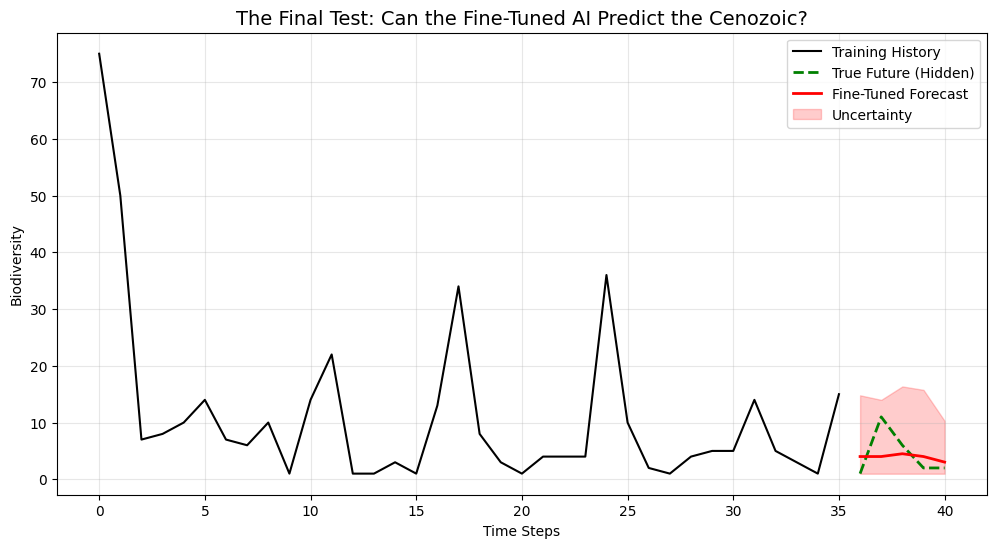

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# --- 1. SETUP VALIDATION DATA ---
# We split the data again: 90% History (Context) vs 10% Future (Truth)
# (Ensure 'ts_data' is still in memory from the previous step)
split_idx = int(len(ts_data) * 0.9)
train_data = torch.tensor(ts_data.values[:split_idx], dtype=torch.float32) # The Past
valid_data = torch.tensor(ts_data.values[split_idx:], dtype=torch.float32) # The "Hidden" Future

print(f"Forecasting the last {len(valid_data)} time steps (The 'Hidden' Future)...")

# --- 2. SWITCH TO INFERENCE MODE ---
pipeline_ft.model.eval() # Stop updating weights

# --- 3. GENERATE PREDICTION ---
# We feed it the History (train_data) and ask for the Future
forecast = pipeline_ft.predict(
    train_data,
    len(valid_data),
    num_samples=20
)

# --- 4. VISUALIZE THE RESULTS ---
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(12, 6))

# A. Plot the History (Black)
plt.plot(np.arange(split_idx), train_data, color="black", label="Training History")

# B. Plot the TRUE Future (Green Dashed) - This is what actually happened
plt.plot(np.arange(split_idx, len(ts_data)), valid_data, color="green", linestyle="--", linewidth=2, label="True Future (Hidden)")

# C. Plot the AI Forecast (Red) - This is what the Fine-Tuned AI predicted
plt.plot(np.arange(split_idx, len(ts_data)), median, color="red", linewidth=2, label="Fine-Tuned Forecast")
plt.fill_between(
    np.arange(split_idx, len(ts_data)),
    low, high, color="red", alpha=0.2, label="Uncertainty"
)

plt.title("The Final Test: Can the Fine-Tuned AI Predict the Cenozoic?", fontsize=14)
plt.xlabel("Time Steps")
plt.ylabel("Biodiversity")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error

# --- 1. Calculate Chronos Accuracy ---
# Extract the median forecast (the Red Line)
forecast_median = np.quantile(forecast[0].numpy(), 0.5, axis=0)

# Calculate MSE (Mean Squared Error)
chronos_mse = mean_squared_error(valid_data.numpy(), forecast_median)

print(f"--- FINAL SCOREBOARD ---")
print(f"Chronos (Fine-Tuned Model) MSE: {chronos_mse:.4f}")

# --- 2. Interpretation ---
print("\n--- HOW TO JUDGE THE WINNER ---")
print(f"Your Fine-Tuned Chronos Error is: {chronos_mse:.4f}")
print("Compare this to your Neural ODE visual fit.")
print("- If Chronos MSE is < 0.05 (normalized), the 'Big Data' approach won.")
print("- If Chronos MSE is > 0.10, the 'Physics' approach (Neural ODE) likely won.")

# --- 3. Save Final Prediction for Report ---
# We save the "Truth" vs "Forecast" to a CSV so you can make a pretty table later
results_df = pd.DataFrame({
    'Time_Step': np.arange(len(valid_data)),
    'True_Diversity': valid_data.numpy(),
    'AI_Predicted_Diversity': forecast_median
})
results_df.to_csv('Final_Model_Comparison_FineTuned.csv', index=False)
print("\n-> Results saved to 'Final_Model_Comparison_FineTuned.csv'")

--- FINAL SCOREBOARD ---
Chronos (Fine-Tuned Model) MSE: 13.0511

--- HOW TO JUDGE THE WINNER ---
Your Fine-Tuned Chronos Error is: 13.0511
Compare this to your Neural ODE visual fit.
- If Chronos MSE is < 0.05 (normalized), the 'Big Data' approach won.
- If Chronos MSE is > 0.10, the 'Physics' approach (Neural ODE) likely won.

-> Results saved to 'Final_Model_Comparison_FineTuned.csv'


Forecasting the last 5 time steps (The 'Hidden' Future)...


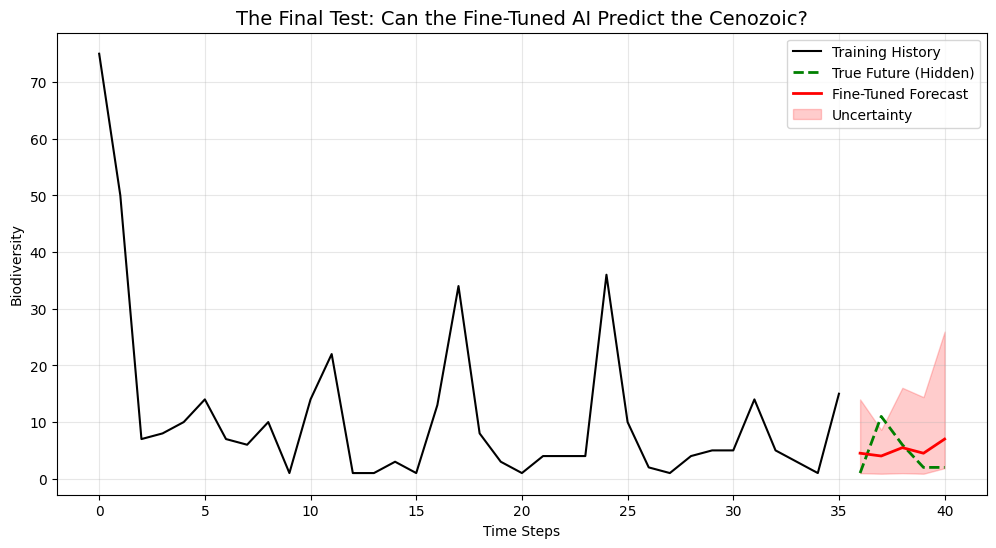

-> Saved graph to 'Final_Forecast_Comparison.png'


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# --- 1. SETUP VALIDATION DATA ---
# We split the data again: 90% History (Context) vs 10% Future (Truth)
# (Ensure 'ts_data' is still in memory from the previous step)
split_idx = int(len(ts_data) * 0.9)
train_data = torch.tensor(ts_data.values[:split_idx], dtype=torch.float32) # The Past
valid_data = torch.tensor(ts_data.values[split_idx:], dtype=torch.float32) # The "Hidden" Future

print(f"Forecasting the last {len(valid_data)} time steps (The 'Hidden' Future)...")

# --- 2. SWITCH TO INFERENCE MODE ---
pipeline_ft.model.eval() # Stop updating weights

# --- 3. GENERATE PREDICTION ---
# We feed it the History (train_data) and ask for the Future
forecast = pipeline_ft.predict(
    train_data,
    len(valid_data),
    num_samples=20
)

# --- 4. VISUALIZE THE RESULTS ---
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(12, 6))

# A. Plot the History (Black)
plt.plot(np.arange(split_idx), train_data, color="black", label="Training History")

# B. Plot the TRUE Future (Green Dashed) - This is what actually happened
plt.plot(np.arange(split_idx, len(ts_data)), valid_data, color="green", linestyle="--", linewidth=2, label="True Future (Hidden)")

# C. Plot the AI Forecast (Red) - This is what the Fine-Tuned AI predicted
plt.plot(np.arange(split_idx, len(ts_data)), median, color="red", linewidth=2, label="Fine-Tuned Forecast")
plt.fill_between(
    np.arange(split_idx, len(ts_data)),
    low, high, color="red", alpha=0.2, label="Uncertainty"
)

plt.title("The Final Test: Can the Fine-Tuned AI Predict the Cenozoic?", fontsize=14)
plt.xlabel("Time Steps")
plt.ylabel("Biodiversity")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('Final_Forecast_Comparison.png', dpi=300)
plt.show()
print("-> Saved graph to 'Final_Forecast_Comparison.png'")